In [139]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist, squareform

# Load and prepare data

In [140]:
# Load the Pueblos dataset
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")
pueblos_cmun = df_pueblos['cmun'].tolist()

In [141]:
# Select only numerical features with more than 2 unique values (non-binary features)
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
df_pueblos_enc = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

In [142]:
# Load the data from all user selection
user_files = os.listdir("../../data/user_output/")
all_user_choices = []

In [143]:
# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    all_user_choices.append(user_df)

# user choices of first user
peter_choices = all_user_choices[0]
peter_choices_cmun = all_user_choices[0].cmun.tolist()

In [144]:
# Select only numerical features with more than 2 unique values (non-binary features)
all_user_choices_enc = []

for df in all_user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    all_user_choices_enc.append(df_non_binary)

peter_choices_enc = all_user_choices_enc[0]

# Construct Graph

## Cosin Similarity

**Graph density** ranges from 0 (no connections) to 1 (fully connected)
- Very low density (<0.01): Too sparse, might have isolated nodes and poor recommendations
- Low density (0.01-0.05): Sparse but workable for large graphs
- Medium density (0.05-0.2): Good balance for recommendation systems
- High density (>0.2): May be too connected, less discriminative recommendations
 
>If density is too high: Increase similarity threshold </br>
>If density is too low: Decrease similarity threshold or use KNN approach

In [145]:
# Construct the Graph
G = nx.Graph()

for i, row in df_pueblos_enc.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = df_pueblos_enc
similarity_matrix = cosine_similarity(feature_matrix)

In [146]:
# Add edges based on similarity threshold
threshold = 0.72  # Adjust threshold based on data distribution

# Use batching for edge creation to avoid memory issues
batch_size = 2000
for i in range(len(feature_matrix)):
    village_i = pueblos_cmun[i]
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            village_j = pueblos_cmun[j]
            G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])

### Evaluate Graph

In [147]:
density = nx.density(G)
print(f"Graph Density: {density:.4f} --> Expected: ~0.01 to 0.1 for a well-structured graph")
# Number of Connected Components: Checks if the graph is fragmented into disconnected pieces
num_components = nx.number_connected_components(G)
print("Number of Connected Components:", num_components, "-->  Expected: 1 (or very few)")  

# Largest Connected Component (LCC): How many nodes belong to the biggest connected group
largest_cc = max(nx.connected_components(G), key=len)
print("Largest Component Size:", len(largest_cc), "-->  Expected: Most nodes (~90% of total)")

# Check for isolated nodes (nodes with no edges)
isolated_nodes = list(nx.isolates(G))
print("Number of Isolated Nodes:", len(isolated_nodes), "-->  Expected: 0 or very few")  


Graph Density: 0.0367 --> Expected: ~0.01 to 0.1 for a well-structured graph
Number of Connected Components: 2 -->  Expected: 1 (or very few)
Largest Component Size: 6820 -->  Expected: Most nodes (~90% of total)
Number of Isolated Nodes: 1 -->  Expected: 0 or very few


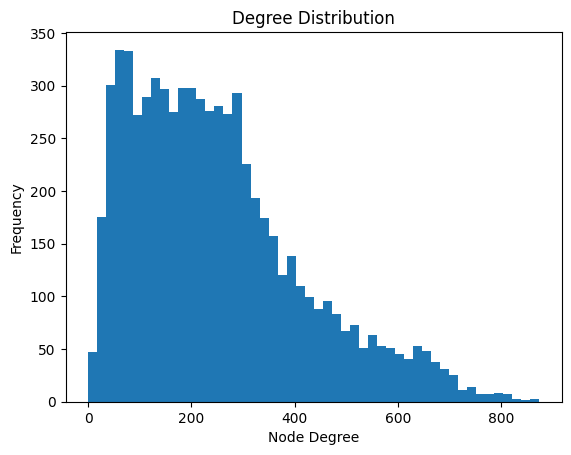

In [148]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50)
plt.title("Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.show()

In [149]:
# Average Clustering Coefficient: Measures the tendency of nodes to form triangles (connections)
clustering_coeff = nx.average_clustering(G)
print("Average Clustering Coefficient:", clustering_coeff)  # Expected: ~0.2 to 0.5

Average Clustering Coefficient: 0.5023385978079307


In [150]:
# # Function to compute graph density for a given threshold
# def compute_graph_density(threshold):
#     G = nx.Graph()
#     for i in range(len(feature_matrix)):
#         village_i = pueblos_cmun[i]
#         for j in range(i + 1, len(feature_matrix)):
#             if similarity_matrix[i, j] > threshold:
#                 village_j = pueblos_cmun[j]
#                 G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])
#     return nx.density(G)

# # Range of thresholds to test
# thresholds = np.linspace(0.5, 0.9, 20)
# densities = [compute_graph_density(threshold) for threshold in thresholds]

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, densities, marker='o')
# plt.title('Graph Density vs. Similarity Threshold')
# plt.xlabel('Similarity Threshold')
# plt.ylabel('Graph Density')
# plt.grid(True)
# plt.show()

In [151]:
# # Visualizing the Graph
# plt.figure(figsize=(10, 7))
# pos = nx.spring_layout(G, seed=42)  # Force-directed layout for better spacing
# nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", edge_color="gray")

# plt.title("Graph Visualization")
# plt.show()

In [166]:
from pyvis.network import Network
import random

random.seed(7)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Dictionary to map cmun to municipality names (Make sure you have this mapping)
cmun_to_municipality = {row["cmun"]: row["municipality"] for _, row in df_pueblos.iterrows()}

# Add nodes with a single color and municipality name as label
for node in sampled_nodes:
    municipality_name = cmun_to_municipality.get(node, str(node))  # Use municipality name or fallback to node ID
    net.add_node(str(node), label=municipality_name, color=f"hsl({partition.get(node, 0) * 40}, 100%, 50%)")

# Function to normalize similarity (maps [0.72, 1] -> [1, 10] width range)
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Add edges with normalized width
for edge in subgraph.edges(data=True):
    node1, node2, attributes = edge
    similarity = attributes.get("weight", 0)  # Extract similarity value
    
    # Normalize similarity to range [1, 10] for edge width
    edge_width = normalize_similarity(similarity)
    
    net.add_edge(str(node1), str(node2), title=f"Similarity: {similarity:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph.html")


interactive_graph.html


In [204]:
from pyvis.network import Network
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define custom colors
colors = {
    'light-coral': '#ee7674',
    'naples-yellow': '#f2dc5d',
    'periwinkle': '#a9afd1',
    'shamrock-green': '#4c9f70',
    'dark-green': '#1a281f'
}

# Map colors to clusters
color_map = {
    2: colors['light-coral'],
    0: colors['shamrock-green'],
    1: colors['periwinkle'],
    3: colors['naples-yellow']
}

# Dictionary to map cmun to municipality names (Make sure you have this mapping)
cmun_to_municipality = {row["cmun"]: row["municipality"] for _, row in df_pueblos.iterrows()}

# Get cluster assignments from df_pueblos
cmun_to_cluster = {row["cmun"]: row["cluster"] for _, row in df_pueblos.iterrows()}

# Define node colors based on cluster
for node in sampled_nodes:
    municipality_name = cmun_to_municipality.get(node, str(node))  # Use municipality name or fallback to node ID
    cluster = cmun_to_cluster.get(node, 0)  # Default to 0 if no cluster info
    
    # Assign color from color_map, defaulting to dark-green if the cluster isn't mapped
    node_color = color_map.get(cluster, colors['dark-green'])

    net.add_node(
        str(node),
        label=municipality_name,
        color=node_color  # Use custom color instead of HSL
    )

# Function to normalize similarity (maps [0.72, 1] -> [1, 10] width range)
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Add edges with normalized width
for edge in subgraph.edges(data=True):
    node1, node2, attributes = edge
    similarity = attributes.get("weight", 0)  # Extract similarity value
    
    # Normalize similarity to range [1, 10] for edge width
    edge_width = normalize_similarity(similarity)
    
    net.add_edge(str(node1), str(node2), title=f"Similarity: {similarity:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph_cluster_colors.html")


interactive_graph_cluster_colors.html


In [164]:
from pyvis.network import Network
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Dictionary to map cmun to municipality names (Make sure you have this mapping)
cmun_to_municipality = {row["cmun"]: row["municipality"] for _, row in df_pueblos.iterrows()}

# Get cluster assignments from df_pueblos
cmun_to_cluster = {row["cmun"]: row["cluster"] for _, row in df_pueblos.iterrows()}

# Define node colors based on cluster
for node in sampled_nodes:
    municipality_name = cmun_to_municipality.get(node, str(node))  # Use municipality name or fallback to node ID
    cluster = cmun_to_cluster.get(node, 0)  # Default to 0 if no cluster info
    
    net.add_node(
        str(node),
        label=municipality_name,
        color=f"hsl({cluster * 40}, 100%, 50%)"  # Adjust color based on cluster
    )

# Function to normalize similarity (maps [0.72, 1] -> [1, 10] width range)
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Add edges with normalized width
for edge in subgraph.edges(data=True):
    node1, node2, attributes = edge
    similarity = attributes.get("weight", 0)  # Extract similarity value
    
    # Normalize similarity to range [1, 10] for edge width
    edge_width = normalize_similarity(similarity)
    
    net.add_edge(str(node1), str(node2), title=f"Similarity: {similarity:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph_cluster.html")

interactive_graph_cluster.html


# Generate Embeddings

In [ ]:
# Generate Node2Vec Embeddings
#node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=50, workers=6)

Computing transition probabilities:   3%|▎         | 204/6821 [00:15<09:40, 11.39it/s]

In [ ]:
# model = node2vec.fit(
#     window=5,    
#     min_count=1, 
#     batch_words=50,  
#     epochs=5,    
#     sg=0,            
#     hs=0,          
#     negative=7        
# )

In [ ]:
display(similarity_matrix)

array([[ 1.        ,  0.723396  ,  0.69736333, ...,  0.72957946,
         0.16038188, -0.06239642],
       [ 0.723396  ,  1.        ,  0.96367783, ...,  0.52713098,
         0.58274212, -0.31754954],
       [ 0.69736333,  0.96367783,  1.        , ...,  0.54329762,
         0.67090616, -0.37992173],
       ...,
       [ 0.72957946,  0.52713098,  0.54329762, ...,  1.        ,
         0.51065835, -0.36601523],
       [ 0.16038188,  0.58274212,  0.67090616, ...,  0.51065835,
         1.        , -0.72235604],
       [-0.06239642, -0.31754954, -0.37992173, ..., -0.36601523,
        -0.72235604,  1.        ]])

In [121]:
from gensim.models import Word2Vec

# Load the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model = Word2Vec.load(model_path)

print(f"Model loaded from {model_path}")

# Load the graph from pickle
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'rb') as f:
    G = pickle.load(f)
    
print(f"Graph saved to {graph_path}")

Model loaded from ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


## Why Do We Use node2vec If We Just Use Cosine Similarity Later?

Good question! Here’s why:

✅ node2vec learns embeddings that capture graph structure (community, structural similarities, etc.).
✅ These embeddings are better than raw features for similarity because they encode relationships beyond direct numerical similarity.
✅ Cosine similarity works on embeddings (not raw data), meaning it measures similarity in a meaningful latent space.

So, node2vec transforms the problem:

Instead of comparing raw village features, we compare graph-informed village embeddings using cosine similarity.

In [122]:
# 3️⃣ Compute Similarity
user_selected_villages = peter_choices_cmun # Example selected villages

selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")

NDCG Score: nan
Top 10 Most Similar Villages:
Village 8902: Similarity 0.7959
Village 17181: Similarity 0.7910
Village 50066: Similarity 0.7877
Village 17020: Similarity 0.7824
Village 43145: Similarity 0.7791
Village 8043: Similarity 0.7699
Village 47161: Similarity 0.7664
Village 17056: Similarity 0.7658
Village 43093: Similarity 0.7652
Village 28002: Similarity 0.7499


C:\Users\Marina\AppData\Local\Temp\ipykernel_25264\145174977.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract top 10 similar villages and their scores
# top_villages = ranked_villages[:10]
# village_ids = [v for v, _ in top_villages]
# similarity_scores = [s for _, s in top_villages]

# # Create a bar plot
# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
# plt.xlabel("Village ID")
# plt.ylabel("Cosine Similarity")
# plt.title("Top 10 Most Similar Villages to User Profile Centroid")
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# # 5. Display top similar villages
# print("Top 10 Most Similar Villages:")
# for village, score in ranked_villages_svd[:10]:
#     print(f"Village {village}: Similarity {score:.4f}")

# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [209]:
from pyvis.network import Network
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define colors
colors = {
    'selected': '#ee7674',  # Light Coral (User-selected villages)
    'top_similar': '#f2dc5d',  # Naples Yellow (Top 50 most similar)
}

# Dictionary to map cmun to municipality names
cmun_to_municipality = {str(row["cmun"]): row["municipality"] for _, row in df_pueblos.iterrows()}

# Convert village IDs to strings
user_selected_villages = [str(v) for v in user_selected_villages]

# Compute similarity scores for all villages
all_village_vectors = {str(v): model.wv[str(v)] for v in G.nodes()}
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Extract top 50 most similar villages
top_50_similar_villages = [str(v) for v, _ in ranked_villages[:50]]

# Combine nodes to be displayed (selected + top similar)
display_nodes = set(user_selected_villages + top_50_similar_villages)

# Add nodes
for node in display_nodes:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping
    
    municipality_name = cmun_to_municipality[node]
    
    # Assign colors
    if node in user_selected_villages:
        node_color = colors['selected']
    elif node in top_50_similar_villages:
        node_color = colors['top_similar']
    else:
        continue  # Ignore other nodes
    
    net.add_node(
        str(node),
        label=municipality_name,
        color=node_color
    )

# Function to normalize similarity for edge width
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Add edges only between user-selected towns and top similar towns
for node in user_selected_villages:
    for similar_town in top_50_similar_villages:
        if node in net.get_nodes() and similar_town in net.get_nodes():
            similarity_score = similarities.get(similar_town, 0)
            edge_width = normalize_similarity(similarity_score)
            net.add_edge(node, similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph_selected_towns.html")


interactive_graph_selected_towns.html


In [211]:
from pyvis.network import Network
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define colors
colors = {
    'centroid': '#a9afd1',  # Periwinkle (Centroid node)
    'top_similar': '#f2dc5d',  # Naples Yellow (Top 50 most similar)
}

# Dictionary to map cmun to municipality names
cmun_to_municipality = {str(row["cmun"]): row["municipality"] for _, row in df_pueblos.iterrows()}

# Convert village IDs to strings
user_selected_villages = [str(v) for v in user_selected_villages]

# Compute centroid vector from selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Compute similarity scores for all villages
all_village_vectors = {str(v): model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Extract top 50 most similar villages
top_50_similar_villages = [str(v) for v, _ in ranked_villages[:50]]

# Only display the centroid and the top 50 similar towns
display_nodes = set(["Centroid"] + top_50_similar_villages)

# Add centroid node
net.add_node(
    "Centroid",
    label="Centroid Vector",
    color=colors['centroid'],
    shape="diamond"
)

# Add nodes for top 50 similar towns
for node in top_50_similar_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]
    
    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['top_similar']
    )

# Function to normalize similarity for edge width
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Connect the centroid to the top 50 most similar towns with weighted edges
for similar_town in top_50_similar_villages:
    if similar_town in net.get_nodes():
        similarity_score = similarities.get(similar_town, 0)
        edge_width = normalize_similarity(similarity_score)
        net.add_edge("Centroid", similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph_centroid.html")


interactive_graph_centroid.html


In [212]:
from pyvis.network import Network
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define colors
colors = {
    'centroid': '#a9afd1',  # Periwinkle (Centroid node)
    'top_similar': '#f2dc5d',  # Naples Yellow (Top 50 most similar)
    'selected': '#ee7674',  # Light Coral (User-selected villages)
    'selected_edge': '#a9afd1'  # Periwinkle for edges from selected towns
}

# Dictionary to map cmun to municipality names
cmun_to_municipality = {str(row["cmun"]): row["municipality"] for _, row in df_pueblos.iterrows()}

# Convert village IDs to strings
user_selected_villages = [str(v) for v in user_selected_villages]

# Compute centroid vector from selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Compute similarity scores for all villages
all_village_vectors = {str(v): model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Extract top 50 most similar villages
top_50_similar_villages = [str(v) for v, _ in ranked_villages[:50]]

# Nodes to be displayed: Centroid, Selected Villages, and Top 50 Similar Towns
display_nodes = set(["Centroid"] + user_selected_villages + top_50_similar_villages)

# Add centroid node
net.add_node(
    "Centroid",
    label="Centroid Vector",
    color=colors['centroid'],
    shape="diamond"
)

# Add user-selected villages
for node in user_selected_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['selected']
    )

# Add top 50 most similar towns
for node in top_50_similar_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['top_similar']
    )

# Function to normalize similarity for edge width
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Connect the centroid to the top 50 most similar towns with weighted edges
for similar_town in top_50_similar_villages:
    if similar_town in net.get_nodes():
        similarity_score = similarities.get(similar_town, 0)
        edge_width = normalize_similarity(similarity_score)
        net.add_edge("Centroid", similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Connect user-selected villages to the centroid with a standard edge
for node in user_selected_villages:
    if node in net.get_nodes():
        net.add_edge("Centroid", node, title="User Selection", width=5, color=colors['selected_edge'])

# Save and display interactive graph
net.show("interactive_graph_with_selected_and_centroid.html")


interactive_graph_with_selected_and_centroid.html


In [213]:
from pyvis.network import Network
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define colors
colors = {
    'centroid': '#a9afd1',  # Periwinkle (Centroid node)
    'top_similar': '#f2dc5d',  # Naples Yellow (Top 50 most similar)
    'selected': '#ee7674',  # Light Coral (User-selected villages)
    'selected_edge': '#a9afd1',  # Periwinkle for edges from selected towns to centroid
    'top5_selected': '#4c9f70'  # Shamrock Green (Top 5 similar towns per selected village)
}

# Dictionary to map cmun to municipality names
cmun_to_municipality = {str(row["cmun"]): row["municipality"] for _, row in df_pueblos.iterrows()}

# Convert village IDs to strings
user_selected_villages = [str(v) for v in user_selected_villages]

# Compute centroid vector from selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Compute similarity scores for all villages
all_village_vectors = {str(v): model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Extract top 50 most similar villages
top_50_similar_villages = [str(v) for v, _ in ranked_villages[:50]]

# Find top 5 most similar towns for each user-selected town
top_5_per_selected = {}
for selected_town in user_selected_villages:
    town_vector = model.wv[selected_town]
    town_similarities = {v: cosine_similarity([town_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
    top_5 = sorted(town_similarities.items(), key=lambda x: x[1], reverse=True)[1:6]  # Skip self (first result)
    top_5_per_selected[selected_town] = [str(v[0]) for v in top_5]

# Nodes to be displayed: Centroid, Selected Villages, Top 50 Similar Towns, and Top 5 per Selected Town
display_nodes = set(["Centroid"] + user_selected_villages + top_50_similar_villages)
for top_5 in top_5_per_selected.values():
    display_nodes.update(top_5)

# Add centroid node
net.add_node(
    "Centroid",
    label="Centroid Vector",
    color=colors['centroid'],
    shape="diamond"
)

# Add user-selected villages
for node in user_selected_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['selected']
    )

# Add top 50 most similar towns
for node in top_50_similar_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['top_similar']
    )

# Add top 5 similar towns per selected village
for selected_town, top_5_list in top_5_per_selected.items():
    for node in top_5_list:
        if node not in cmun_to_municipality:
            continue  # Skip if the node has no mapping

        municipality_name = cmun_to_municipality[node]

        net.add_node(
            str(node),
            label=municipality_name,
            color=colors['top5_selected']
        )

# Function to normalize similarity for edge width
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Connect the centroid to the top 50 most similar towns with weighted edges
for similar_town in top_50_similar_villages:
    if similar_town in net.get_nodes():
        similarity_score = similarities.get(similar_town, 0)
        edge_width = normalize_similarity(similarity_score)
        net.add_edge("Centroid", similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Connect user-selected villages to the centroid with a standard edge
for node in user_selected_villages:
    if node in net.get_nodes():
        net.add_edge("Centroid", node, title="User Selection", width=5, color=colors['selected_edge'])

# Connect user-selected villages to their top 5 most similar towns with weighted edges
for selected_town, top_5_list in top_5_per_selected.items():
    for similar_town in top_5_list:
        if selected_town in net.get_nodes() and similar_town in net.get_nodes():
            similarity_score = similarities.get(similar_town, 0)
            edge_width = normalize_similarity(similarity_score)
            net.add_edge(selected_town, similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Save and display interactive graph
net.show("interactive_graph_with_top5.html")


interactive_graph_with_top5.html


## TSVD dimensionality reduction on all centroids

In [179]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5)

In [188]:
from gensim.models import Word2Vec

# Load the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model = Word2Vec.load(model_path)

print(f"Model loaded from {model_path}")

# Load the graph from pickle
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'rb') as f:
    G = pickle.load(f)
    
print(f"Graph saved to {graph_path}")

Model loaded from ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


In [189]:
# Ensure all CMUNs in the graph are in the DataFrame
graph_cmun_set = set(G.nodes())
df_cmun_set = set(df_pueblos['cmun'])

missing_in_df = graph_cmun_set - df_cmun_set
missing_in_graph = df_cmun_set - graph_cmun_set

print(f"CMUNs in graph but not in DataFrame: {missing_in_df}")
print(f"CMUNs in DataFrame but not in graph: {missing_in_graph}")

# Remove nodes from the graph that are not in the DataFrame
for cmun in missing_in_df:
    G.remove_node(cmun)

# Optionally, add nodes to the graph that are in the DataFrame but not in the graph
for cmun in missing_in_graph:
    G.add_node(cmun, **df_pueblos[df_pueblos['cmun'] == cmun].to_dict('records')[0])

CMUNs in graph but not in DataFrame: set()
CMUNs in DataFrame but not in graph: set()


In [190]:
# 2. Get all village vectors (handling missing nodes)
all_village_vectors = {}
for v in G.nodes():
    try:
        all_village_vectors[v] = model.wv[str(v)]
    except KeyError:
        print(f"Warning: Village {v} not found in model")
        continue

# 3. Apply TruncatedSVD to reduce dimensionality
all_vectors = np.array(list(all_village_vectors.values()))
pueblos_latent_features = svd.fit_transform(all_vectors)

In [191]:
user_selected_villages = peter_choices
user_selected_villages

,cmun,municipality,province,autonomous_community,altitude,longitude,latitude,towns_in_vicinity,total_population,nearest_airport,...,enc_scaled__score_hospital_distance,enc_scaled__score_area_economy,enc_scaled__score_economy,enc_scaled__score_connectivity,enc_scaled__female,enc_scaled__count_of_stations,enc_scaled__number_of_houses,enc_scaled__total_population,enc_scaled__latitude,enc_scaled__longitude
0,34176,Sotobañado y Priorato,Palencia,Castilla León,893.8764,-4.441792,42.59135,"(9024, 9045, 9088, 9148, 9175, 9182, 9211, 924...",158,Aeropuerto de Burgos,...,-0.892572,-0.400296,-0.400296,-0.004673,-0.609687,-0.321851,-0.638404,-0.605892,1.019706,-0.534486
1,49234,Venialbo,Zamora,Castilla León,714.8421,-5.536571,41.38918,"(37017, 37019, 37033, 37034, 37062, 37073, 371...",439,Aeropuerto de Salamanca,...,-0.118287,-0.400296,-0.400296,1.012914,-0.385373,-0.321851,-0.103262,-0.384753,0.261246,-0.958476
2,4046,Fondón,Almería,Andalucía,858.4697,-2.858356,36.97942,"(4001, 4002, 4003, 4005, 4007, 4010, 4011, 401...",1133,Aeropuerto de Almería,...,-0.505430,0.268503,0.268503,0.885919,0.146978,-0.321851,0.878231,0.161404,-2.520915,0.078753
3,26110,Ojacastro,La Rioja,La Rioja,792.9922,-3.005141,42.34657,"(1011, 1014, 1022, 1028, 1033, 1034, 1041, 105...",179,Aeropuerto de Burgos,...,-0.892572,-0.400296,-0.400296,0.892432,-0.597049,-0.321851,-0.488421,-0.589365,0.865272,0.021906
4,26119,Préjano,La Rioja,La Rioja,705.9279,-2.179706,42.18618,"(26002, 26003, 26004, 26005, 26006, 26007, 260...",220,Aeropuerto de Logroño - Agoncillo,...,-0.118287,-0.400296,-0.400296,-1.632813,-0.559137,-0.321851,-0.508818,-0.557100,0.764081,0.341584


In [198]:
# valid_villages = []
# selected_vectors = []

# for v in user_selected_villages:
#     try:
#         vector = model.wv[str(v)]
#         selected_vectors.append(vector)
#         valid_villages.append(v)
#     except KeyError:
#         print(f"Warning: Village {v} not found in model")

In [201]:
# display(selected_vectors)
user_latent_features = svd.transform(np.array(selected_vectors))

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [200]:
# Reduce selected vectors using the same transformation
# 4. Calculate similarities in reduced space
similarities_svd = cosine_similarity(user_latent_features, pueblos_latent_features)

df_similarities = pd.DataFrame()
df_similarities['similarity'] = similarities_svd.mean(axis=0)

df_similarities['cmun'] = G.nodes().keys()
df_similarities = df_similarities.sort_values(by='similarity', ascending=False)

df_similarities

,similarity,cmun
4667,0.419981,19326
156,0.418730,39100
245,0.413861,39055
233,0.409342,39022
2993,0.400129,8029
...,...,...
5565,-0.395902,16104
4044,-0.400678,19186
4937,-0.401917,16206
3534,-0.402735,40082


C:\Users\Marina\AppData\Local\Temp\ipykernel_25264\1651480735.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))


NDCG Score: nan
Top 10 Most Similar Villages:
Village 19326: Similarity 0.4200
Village 39100: Similarity 0.4187
Village 39055: Similarity 0.4139
Village 39022: Similarity 0.4093
Village 8029: Similarity 0.4001
Village 8158: Similarity 0.3979
Village 19117: Similarity 0.3959
Village 19143: Similarity 0.3949
Village 8273: Similarity 0.3937
Village 39032: Similarity 0.3927

Top 10 Most Similar Villages with Names:
Village 19326 (Yebes): Similarity 0.4200
Village 39100 (Villafufre): Similarity 0.4187
Village 39055 (Potes): Similarity 0.4139
Village 39022 (Cillorigo de Liébana): Similarity 0.4093
Village 8029 (Cabrera de Mar): Similarity 0.4001
Village 8158 (Papiol, El): Similarity 0.3979
Village 19117 (Fontanar): Similarity 0.3959
Village 19143 (Horche): Similarity 0.3949
Village 8273 (Subirats): Similarity 0.3937
Village 39032 (Hermandad de Campoo de Suso): Similarity 0.3927


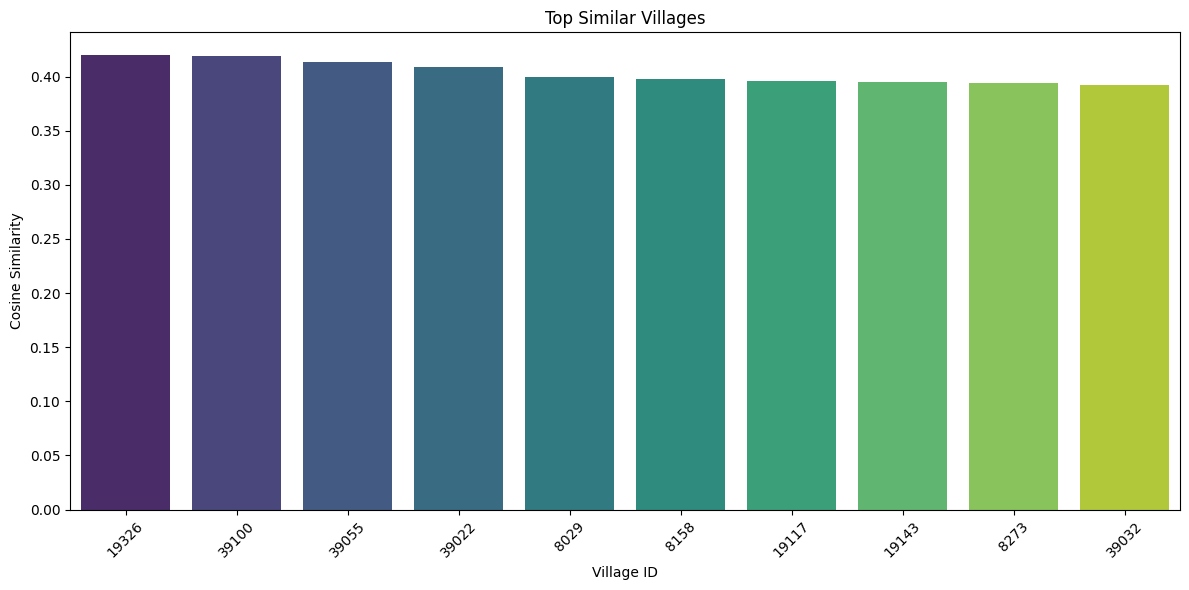

In [195]:
# Convert df_similarities to the ranked_villages format that ndcg_at_k expects
ranked_villages_from_df = list(zip(df_similarities['cmun'], df_similarities['similarity']))

# Calculate NDCG score for the recommendations
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

# Calculate NDCG at 10
ndcg_score = ndcg_at_k(ranked_villages_from_df, user_choices_cmun, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages_from_df[:10]:
    print(f"Village {village}: Similarity {score:.4f}")
    
# Optional: Add village names if available
if 'municipality' in df_pueblos.columns:
    # Create a lookup dictionary for village names
    cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
    
    print("\nTop 10 Most Similar Villages with Names:")
    for village, score in ranked_villages_from_df[:10]:
        village_name = cmun_to_name.get(village, "Unknown")
        print(f"Village {village} ({village_name}): Similarity {score:.4f}")

# Visualize top similarities with a bar chart
top_n = 10
village_ids = [str(v) for v, _ in ranked_villages_from_df[:top_n]]
similarity_scores = [score for _, score in ranked_villages_from_df[:top_n]]

plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
plt.title('Top Similar Villages')
plt.xlabel('Village ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [214]:
from pyvis.network import Network
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(157)

# Create Pyvis Network
net = Network(height="800px", width="100%", notebook=True)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.9,
      "avoidOverlap": 0.5
    }
  }
}
""")

# Define colors
colors = {
    'centroid': '#a9afd1',  # Periwinkle (Centroid node)
    'top_similar': '#f2dc5d',  # Naples Yellow (Top 50 most similar)
    'selected': '#ee7674',  # Light Coral (User-selected villages)
    'selected_edge': '#a9afd1',  # Periwinkle for edges from selected towns to centroid
}

# Dictionary to map cmun to municipality names
cmun_to_municipality = {str(row["cmun"]): row["municipality"] for _, row in df_pueblos.iterrows()}

# Convert village IDs to strings
user_selected_villages = [str(v) for v in user_selected_villages]

# Compute centroid similarity directly from df_similarities
df_similarities["cmun"] = df_similarities["cmun"].astype(str)

# Extract top 50 most similar villages using df_similarities
top_50_similar_villages = df_similarities["cmun"].head(50).tolist()

# Nodes to be displayed: Centroid, Selected Villages, and Top 50 Similar Towns
display_nodes = set(["Centroid"] + user_selected_villages + top_50_similar_villages)

# Add centroid node
net.add_node(
    "Centroid",
    label="Centroid Vector",
    color=colors['centroid'],
    shape="diamond"
)

# Add user-selected villages
for node in user_selected_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['selected']
    )

# Add top 50 most similar towns
for node in top_50_similar_villages:
    if node not in cmun_to_municipality:
        continue  # Skip if the node has no mapping

    municipality_name = cmun_to_municipality[node]

    net.add_node(
        str(node),
        label=municipality_name,
        color=colors['top_similar']
    )

# Function to normalize similarity for edge width
def normalize_similarity(similarity, min_sim=0.72, max_sim=1, min_width=1, max_width=8):
    return min_width + (max_width - min_width) * ((similarity - min_sim) / (max_sim - min_sim))

# Connect the centroid to the top 50 most similar towns with weighted edges
for _, row in df_similarities.head(50).iterrows():
    similar_town = str(row["cmun"])
    similarity_score = row["similarity"]

    if similar_town in net.get_nodes():
        edge_width = normalize_similarity(similarity_score)
        net.add_edge("Centroid", similar_town, title=f"Similarity: {similarity_score:.2f}", width=edge_width)

# Connect user-selected villages to the centroid with a standard edge
for node in user_selected_villages:
    if node in net.get_nodes():
        net.add_edge("Centroid", node, title="User Selection", width=5, color=colors['selected_edge'])

# Save and display interactive graph
net.show("interactive_graph_svd_centroid.html")


interactive_graph_svd_centroid.html


### Compute the Graph Density
Graph density tells us how connected the graph is.
A fully connected graph has density 1, while a sparse graph has density close to 0.

If density > 0.1, your graph might be too dense.
If density < 0.01, it might be too sparse.

### Draws the network graph

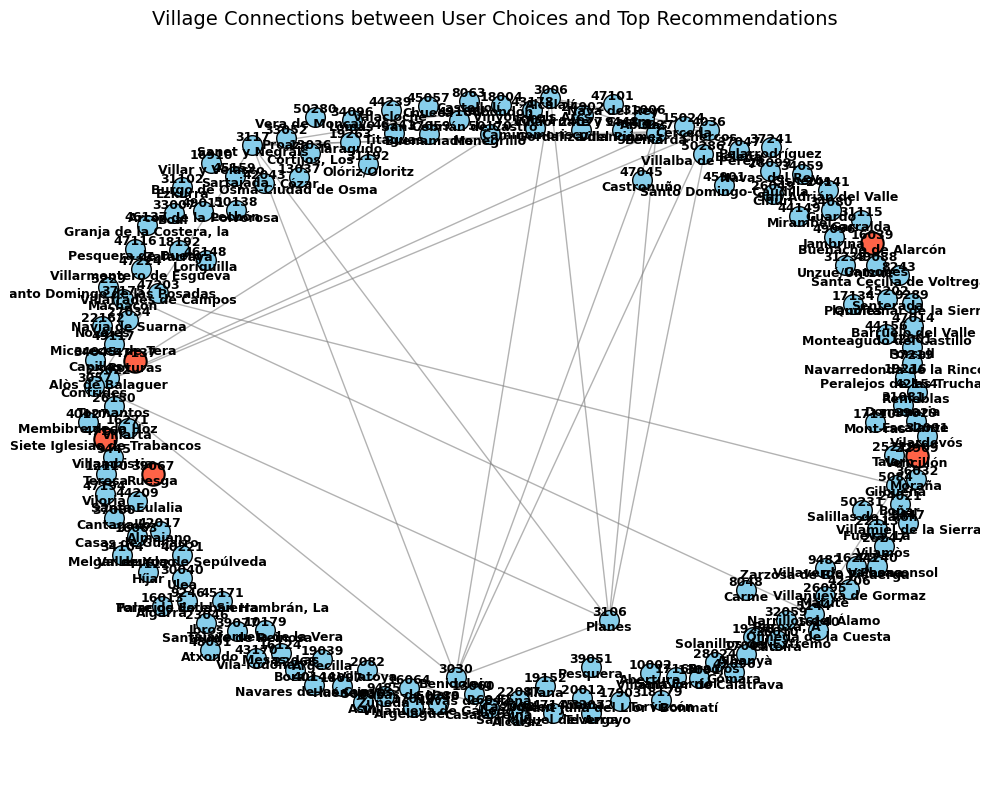

In [ ]:
def plot_small_labeled_subgraph(G, nodes_to_show, figsize=(10, 8), 
                               highlight_nodes=None, title="Village Connection Subgraph",
                               with_labels=True, node_size=200, 
                               df_pueblos=None):
    """
    Plot a small subgraph with CMUN labels visible.
    
    Parameters:
    - G: NetworkX graph
    - nodes_to_show: List of nodes to include in the visualization
    - figsize: Figure size tuple (width, height)
    - highlight_nodes: List of nodes to highlight (e.g., user selections)
    - title: Plot title
    - with_labels: Whether to show node labels
    - node_size: Size of nodes in the plot
    - df_pueblos: DataFrame with village information for name lookup
    """
    # Create subgraph of specified nodes
    H = G.subgraph(nodes_to_show)
    
    plt.figure(figsize=figsize)
    
    # Create a layout with more spacing for labels
    pos = nx.spring_layout(H, k=1.5, seed=42)  # k controls spacing
    
    # Draw edges first
    nx.draw_networkx_edges(
        H, pos,
        width=1.0,
        alpha=0.6,
        edge_color='gray'
    )
    
    # Prepare node labels
    if with_labels:
        if df_pueblos is not None:
            # Create a lookup dictionary for municipality names
            cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
            labels = {node: f"{node}\n{cmun_to_name.get(node, '')}" for node in H.nodes()}
        else:
            labels = {node: str(node) for node in H.nodes()}
    
    # Draw regular nodes
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=[n for n in H.nodes() if highlight_nodes is None or n not in highlight_nodes],
        node_size=node_size,
        node_color='skyblue',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw highlighted nodes if any
    if highlight_nodes:
        nx.draw_networkx_nodes(
            H, pos,
            nodelist=[n for n in H.nodes() if n in highlight_nodes],
            node_size=node_size*1.3,
            node_color='tomato',
            edgecolors='black',
            linewidths=1.5
        )
    
    # Draw labels
    if with_labels:
        nx.draw_networkx_labels(
            H, pos,
            labels=labels,
            font_size=9,
            font_weight='bold'
        )
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# 1. Show top recommendations and user selections
selected_nodes = user_choices_cmun
top_recommendations = [village for village, score in ranked_villages_from_df[:150]]
nodes_to_show = selected_nodes + top_recommendations

# 2. Show a small sample around a chosen node
# central_node = user_choices_cmun[0]  # First user choice
# neighbors = list(G.neighbors(central_node))
# nodes_to_show = [central_node] + neighbors[:15]  # Central node plus up to 15 neighbors

# Make the visualization
plot_small_labeled_subgraph(
    G, 
    nodes_to_show=nodes_to_show, 
    highlight_nodes=selected_nodes,
    title="Village Connections between User Choices and Top Recommendations",
    df_pueblos=df_pueblos
)